# Introduction to Bansal and Yaron (2004)

The long-run risk model (Bansal and Yaron, 2004) builds on the Epstein-Zin's utility, which separates the elasticity of intertemporal substitution (EIS) and the relative risk aversion (RRA).

\begin{equation*}
V_t  =\left[(1-\beta) C_t^\rho+\beta E_t\left[V_{t+1}^\alpha\right]^{\rho /\alpha}\right]^{1 / \rho}
\end{equation*}

where $\alpha = 1-\gamma$, $\gamma$ is the RRA; $\rho = 1-1/\psi$, $\psi$ is the EIS; $\beta$ is the discount factor. BY2004 models fluctuating economic uncertainty as time-varying volatility of consumption growth. 

The DGPs are 

$$
\begin{aligned} 
\Delta c_{t+1} & =\mu+x_t+\sigma_t \varepsilon_{t+1}^c \\ 
\Delta d_{t+1} & =\mu+\phi x_t+\varphi_d \sigma_t \varepsilon_{t+1}^d \\ 
x_{t+1} & =\rho x_t+\varphi_e \sigma_t \varepsilon_{t+1}^x \\ 
\sigma_{t+1}^2 & =\sigma^2+\nu_1\left(\sigma_t^2-\sigma^2\right)+\sigma_w \varepsilon_{t+1}^\sigma
\end{aligned}
$$

where $(x_t,\sigma^2_t)$ are the state variables of the economy. $\Delta c_t$ and $\Delta d_t$ are the log consumption growth and the log dividend growth respectively. $x_t$ can be interpreted as the health of the economy and $\sigma_t$ is the volatility of the economy. The parameter $\phi$ can be interpreted as the leverage ratio on expected consumption growth. 

# Value Function

The value-consumption ratio $\mathcal{V}_t$ is time irrelevant, and only depends on the state variables $(x_t, \sigma^2_t)$, i.e., $\mathcal{V}_t = \mathcal{V}(x_t, \sigma^2_t)$. I use a 5th order polynomial function to fit $\mathcal{V}(x_t, \sigma^2_t)$ and solve it iteratively in the below bellman equation. 

\begin{equation*}
\mathcal{V}_t=[1-\beta+\beta \mathcal{M}_t^{\rho}]^{1 / \rho}, \ \mathcal{M}_t = E_t[\mathcal{V}_{t+1}^\alpha e^{\alpha \Delta c_{t+1}}]^{1/\alpha}
\end{equation*}

## Algorithm: Polynomial Approximation

Step 0. Write $\mathcal{V}(x, \sigma^2; b)$ as the 5-th order polynomial function with $b$ as the parameters, and choose the approximation grid, $x = {x_1,\dots,x_{n_x}}$, $\sigma^2 = {\sigma^2_1,\dots,\sigma^2_{n_s}}$. Make initial guess $\mathcal{V}(x_t, \sigma^2_t)$, and choose stopping criterion. (Note, the expectation is approximated by the Gauss-Chebyshev quadrature).

Step 1. **Maximization step**: Compute $v_{ij} = (T \mathcal{V}(\dot,b^{(t)})(x_i, \sigma^2_j)$ for all $(x_i, \sigma^2_j) \in (x, \sigma^2)$.

Step 2. **Fitting step**: Update $b^{(t+1)}$ such that $\mathcal{V}(x, \sigma^2; b^{(t+1)})$ approximates the data $(v_{ij},(x_i,\sigma_j))$. 

Step 3. If $\mathcal{V}(x, \sigma^2; b^{(t+1)}) − \mathcal{V}(x, \sigma^2; b^{(t)}) < tol$, STOP; else go to step 1.

(see the detail at [Computational Economics by Kenneth L. Judd](https://kenjudd.org/teaching/university-of-zurich-2020/))

In [1]:
import numpy as np
from numpy.polynomial.chebyshev import chebpts1
from math import pi
from scipy.stats import norm
import torch 
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import cm

torch.cuda.empty_cache()

In [2]:
# return state space & partition
KS_min      = 0.65
KS_max      = 1.35
nKS         = 10000
KS_vec      = np.linspace(KS_min,KS_max,nKS)

# calibration
alpha  = 1-10      # 1-RRA
rho    = 1-1/1.5   # 1-1/EIS
beta   = 0.998     # time discount factor
g      = 0.0015    # mean growth rate
rho_x  = 0.979     # persistence of x
psi_e  = 0.044     # vol scaling in x
phi    = 3         # x scaling in delD
psi_d  = 4.5       # vol scaling in delD 
sig2   = 0.0078**2 # mean of sig_t^2
v_1    = 0.987     # persistence of sig_t^2
sig_w  = 0.23*1e-5 # vol of sig_t^2
S2min  = 1e-12
nX = 100
nS2 = 100

degree = 5

In [3]:
std_sig2 = sig_w/np.sqrt(1-v_1**2)
s2_vec   = np.clip(np.linspace(sig2-5*std_sig2,sig2+5*std_sig2,nS2), S2min, None ) # grid for sig2, set sig2=S2min in sig2<S2min
s2_vec   = np.unique(s2_vec)
nS2      = len(s2_vec)
std_x    = np.sqrt(psi_e**2*s2_vec[-1]/(1-rho_x**2))
x_vec    = np.linspace(-5*std_x,5*std_x,nX) # grid for x
x_grid,s2_grid  = np.meshgrid(x_vec,s2_vec)
x_grid = x_grid.reshape((-1,1))
s2_grid = s2_grid.reshape((-1,1))

n = 50
a = -7
b = -a
Cheb_nodes = chebpts1(n) # n Chebyshev nodes in [-1,1]
nodes = (b-a)*(Cheb_nodes+1)/2 + a
PE = pi*(b-a)/(2*n) * (norm.pdf(nodes) * np.sqrt(1-Cheb_nodes**2)) 
PE2 = np.kron(PE,PE).reshape((-1,1))
nodesX = np.kron(nodes,np.ones((1,n)))
nodesS = np.kron(np.ones((1,n)),nodes)

s2p = np.clip(sig2 + v_1*(s2_grid-sig2) + sig_w*nodesS, S2min, None) # note. duplicated with Smin
xp  = rho_x*x_grid + psi_e*np.sqrt(s2_grid)*nodesX

In [4]:
def polyvander2d(a,b,degree, device):
    # note: polyvander2d in numpy generates a different matrix than this method
    # a and b are 1D arrays
    a = a.reshape(-1)
    b = b.reshape(-1)
    ncols = (degree+1)*(degree+2)//2
    if len(a) != len(b):
        raise ValueError('a and b must have the same length')
    nrows = len(a)
    X = torch.ones((nrows,ncols), dtype=torch.float64, device=device)
    for i in range(1, degree+1):
        X[:,i*(i+1)//2:(i+1)*(i+2)//2] = torch.vander(a,i+1,increasing=True) * torch.vander(b,i+1)
    return X

def poly_pred(X, theta): 
    return X @ theta

def poly_fit(X, y):
    return torch.linalg.pinv(X.T @ X) @ X.T @ y.reshape((-1,1))

def poly2_pred(X, theta):
    return torch.max(X @ theta, torch.tensor(0.0, dtype=torch.float64, device='cuda'))

def loss_fn(y_pred, y_true):
    return torch.mean((y_pred-y_true)**2)
    
def T(s, x, Xp, theta, shape_VC):
    vcp = poly_pred(Xp, theta).reshape(shape_VC)
    mc = (torch.exp(alpha*(g+x)+(alpha**2)*s/2) * ((vcp**alpha) @ PE2))**(1/alpha)
    return (1-beta+beta*(mc**rho))**(1/rho)

s2_grid = torch.tensor(s2_grid, dtype=torch.float64)
x_grid = torch.tensor(x_grid, dtype=torch.float64)
s2p = torch.tensor(s2p, dtype=torch.float64)
xp = torch.tensor(xp, dtype=torch.float64)
PE2 = torch.tensor(PE2, dtype=torch.float64)

theta = torch.zeros(((degree+1)*(degree+2)//2,1), dtype=torch.float64, device='cuda')
theta[0] = 1.0
X = polyvander2d(s2_grid, x_grid, degree, device='cpu')
X = X.to('cuda')
Xp = polyvander2d(s2p, xp, degree, device='cpu') # calculate Xp before loop to save time, instead of calculating it in each iteration
Xp = Xp.to('cuda')
shape_VC = s2p.shape

s2_grid = s2_grid.to('cuda')
x_grid = x_grid.to('cuda')
PE2 = PE2.to('cuda')

In [ ]:
vc0 = torch.inf
while True:
    vc = T(s2_grid, x_grid, Xp, theta, shape_VC)
    theta = poly_fit(X, vc)
    dv = torch.max(torch.abs(vc-vc0))
    # print(dv)
    if dv <1e-6:
        print('Converged')
        break
    theta0 = theta
    vc0 = vc

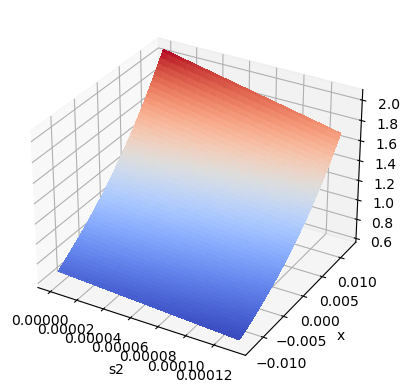

In [6]:
surface = vc.reshape((nS2,nX)).to('cpu').detach().numpy()
xx, ss = np.meshgrid(x_vec,s2_vec)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(ss, xx, surface, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('s2')
ax.set_ylabel('x')
plt.show()

# Price-Dividend

$\mathcal{P}_t=E_t\left[\beta e^{(\alpha-1) \Delta c_{t+1}}\left(\frac{\mathcal{V}_{t+1}}{\mathcal{M}_t}\right)^{\alpha-\rho}\left(\mathcal{P}_{t+1}+1\right) e^{\Delta d_{t+1}}\right]$

D_term = $E_t[e^{\Delta d_{t+1}}]$

EU_term = $E_t[\beta e^{(\alpha-1) \Delta c_{t+1}}]$

EZ_term = $\left(\frac{\mathcal{V}_{t+1}}{\mathcal{M}_t}\right)^{\alpha-\rho}$

MD_term = EU_term * D_term = $E_t[\beta e^{(\alpha-1) \Delta c_{t+1}}e^{\Delta d_{t+1}}]$

In [7]:
EU_term   = beta * torch.exp((alpha-1)*(g+x_grid)+(alpha-1)**2*s2_grid/2) # (nS2*nX)x1
D_term = torch.exp(g + phi*x_grid + psi_d**2*s2_grid/2)
MD_term = EU_term * D_term
vcp = poly_pred(Xp, theta).reshape(shape_VC) # (nS2*nX)x(n*n)
mc = (torch.exp(alpha*(g+x_grid)+(alpha**2)*s2_grid/2) * ((vcp**alpha) @ PE2))**(1/alpha) # (nS2*nX)x1
EZ_term = (vcp/mc)**(alpha-rho) # (nS2*nX)x(n*n)

def T_PD(MD_term, EZ_term, theta_PD):
    PDp = poly_pred(Xp, theta_PD).reshape(shape_VC)
    return MD_term * ((EZ_term *(1+PDp)) @ PE2)

theta_PD = torch.zeros(((degree+1)*(degree+2)//2,1), dtype=torch.float64, device='cuda')
theta_PD[0] = 1.0

In [ ]:
PD0 = torch.inf
while True:
    PD = T_PD(MD_term, EZ_term, theta_PD)
    theta_PD = poly_fit(X, PD)
    dPD = torch.max(torch.abs(PD-PD0))
    # print(dPD)
    if dPD <1e-6:
        print('Converged')
        break
    theta_PD0 = theta_PD
    PD0 = PD

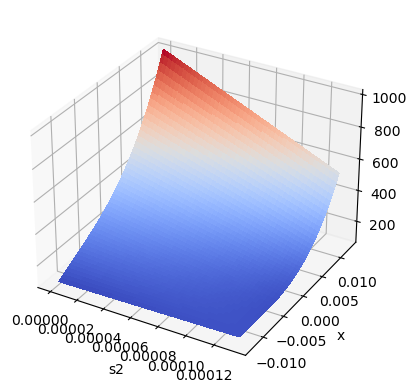

In [9]:
surface = PD.reshape((nS2,nX)).to('cpu').detach().numpy()
xx, ss = np.meshgrid(x_vec,s2_vec)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(ss, xx, surface, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('s2')
ax.set_ylabel('x')
plt.show()

# Introduction to Beason Schreindorfer (2022)

Beason Schreindorfer (2022) uses option prices and realized returns to decompose risk premia into different parts of the return state space. In contrast to other papers mainly focusing on the first moment of the equity premium, BS2022 discusses the fraction of equity premium. Intuitively, the fraction of equity premium measures the uneven importance of returns. For example,  investors may care more about a -20\% return instead of a -5\% return, so investors may require a higher risk premium when the return is around -20\% than around -5\%. 

The risk-neutral density can be retrieved by option data. Specifically, the risk-neutral density $f^*(X)$ is the second derivative of the put option price $P(X)$ with a strike price $X$ times the risk-free rate. And $f^*(R_t) = S_t \times f^*(S_t)$.
$$
\begin{aligned}
P_t(X) & =\frac{1}{R_{t: t+T}^f} \int_0^{\infty} \max (0, X-s) f_t^*(s) d s \\
& =\frac{1}{R_{t: t+T}^f} \int^X_{0}(s-X) f_t^*(s) d s\\
\frac{\partial}{\partial X}P_t(X) & =\frac{1}{R_{t: t+T}^f} \int^X_{0} f_t^*(s) d s \\
\frac{\partial^2}{\partial X^2} P_t(X) & =\frac{1}{R_{t: t+T}^f} f_t^*(X)
\end{aligned}
$$

Based on the numerical method and some innocuous assumption, BS2022 calculates the risk-neutral probability $f^*(R)$ and the real probability $f(R)$. 

To decompose the equity premium, BS2022 defines
\begin{equation*}
\mathrm{EP}(x) \equiv \frac{\int_{-1}^x R\left[f(R)-f^*(R)\right] d R}{\int_{-1}^{\infty} R\left[f(R)-f^*(R)\right] d R}
\end{equation*}
which measures the fraction of the average equity premium that is associated with returns below x.

The put option price $P(X)$ in Bansal Yaron (2004) is 
\begin{align*}
P(X_t) 
&= E_t[M_{t+1}X_t \mathbf{1}_{\Delta d_{t+1} \leq log(X_t\frac{\mathcal{P}_{t+1}}{\mathcal{P}_{t}})} - M_{t+1}\frac{\mathcal{P}_{t+1}}{\mathcal{P}_{t}} e^{\Delta d_{t+1}} \mathbf{1}_{\Delta d_{t+1} \leq log(X_t\frac{\mathcal{P}_{t+1}}{\mathcal{P}_{t}})}] \\
&= E_t[\beta e^{(\alpha-1) \Delta c_{t+1}} \left(\frac{\mathcal{V}_{t+1}}{\mathcal{M}_t}\right)^{\alpha-\rho} X_t \Phi(\lambda_d) - \beta e^{(\alpha-1) \Delta c_{t+1}}e^{\Delta d_{t+1}} \left(\frac{\mathcal{V}_{t+1}}{\mathcal{M}_t}\right)^{\alpha-\rho} \frac{\mathcal{P}_{t+1}}{\mathcal{P}_{t}}\Phi(\lambda_d-\varphi_d \sigma_t)]
\end{align*}

$\displaystyle \lambda_d = \frac{log(X_t\frac{\mathcal{P}_{t+1}}{\mathcal{P}_{t}}) - \mu - \phi x_t}{\varphi_d \sigma_t}$

The 2nd-order derivative of the put option price $\frac{\partial^2}{\partial X^2} P_t(X)$ is approximated by the finite difference method.

$$\frac{\partial^2}{\partial X^2} P_t(X^i) = \frac{P^{i-1} - 2P^{i} + P^{i+1}}{\Delta X^2}$$

Below are some notations in the code

DpD = $\frac{\mathcal{P}_{t+1}}{\mathcal{P}_{t}}$

D_term = $E_t[e^{\Delta d_{t+1}}]$

EU_term = $E_t[\beta e^{(\alpha-1) \Delta c_{t+1}}]$

EZ_term = $\left(\frac{\mathcal{V}_{t+1}}{\mathcal{M}_t}\right)^{\alpha-\rho}$

MD_term = EU_term * D_term = $E_t[\beta e^{(\alpha-1) \Delta c_{t+1}}e^{\Delta d_{t+1}}]$

In [10]:
# Ergodic simulation 
Tinit     = 1000000
burn_in   = 1000
x_sim     = np.zeros((Tinit+burn_in,1))
s2_sim    = np.zeros((Tinit+burn_in,1))
x_sim[0]  = 0
s2_sim[0] = sig2
for t in tqdm(range(1,Tinit+burn_in)):
    s2_sim[t] = np.clip(sig2+v_1*(s2_sim[t-1]-sig2)+sig_w*np.random.randn(), S2min, None)
    x_sim[t]  = rho_x*x_sim[t-1]+psi_e*np.sqrt(s2_sim[t-1])*np.random.randn()
x_sim = x_sim[burn_in:]
s2_sim = s2_sim[burn_in:]
x_sim = torch.tensor(x_sim, dtype=torch.float64, device='cpu')
s2_sim = torch.tensor(s2_sim, dtype=torch.float64, device='cpu')
X_sim = polyvander2d(s2_sim, x_sim, degree, device='cpu')
X_sim = X_sim.to('cuda')

  0%|          | 0/1000999 [00:00<?, ?it/s]

100%|██████████| 1000999/1000999 [00:18<00:00, 53935.55it/s]


In [11]:
## yield curve
EM        = (EU_term * (EZ_term @ PE2)).reshape((nS2,nX))

## CONDITIONAL f and f*
delKS = 0.001
KS_vec = torch.arange(KS_min,KS_max,delKS, device='cuda', dtype=torch.float64)
KS_vec = KS_vec.reshape((-1,1,1))
PDp = poly_pred(Xp, theta_PD).reshape(shape_VC)
DpD = PDp/PD
DpD1 = (PDp+1)/PD
coef_term1 = EU_term *EZ_term
coef_term2 = EU_term * D_term * EZ_term * DpD

In [12]:
# # # release GPU memory
del EU_term, D_term, MD_term, EZ_term, vcp, mc, PDp, PD, PD0, vc, vc0
del Xp, xp, s2p, x_sim, s2_sim
torch.cuda.empty_cache()

# divide KS_vec into 50 parts
Put = torch.zeros((KS_vec.shape[0],nS2,nX), device='cuda', dtype=torch.float64)
FP = torch.zeros((KS_vec.shape[0],nS2,nX), device='cuda', dtype=torch.float64)
KS_vec_chunks = torch.split(KS_vec, 5)
i = 0
for K in tqdm(KS_vec_chunks):
    lamb_d = (torch.log(K/DpD)-g-phi*x_grid)/(psi_d*torch.sqrt(s2_grid))
    cdf1 = torch.distributions.normal.Normal(0, 1).cdf(lamb_d)
    cdf2 = torch.distributions.normal.Normal(0, 1).cdf(lamb_d - psi_d*torch.sqrt(s2_grid))
    Put[i:(i+5),:,:] = ((coef_term1 * K * cdf1 - coef_term2 * cdf2) @ PE2).reshape((-1,nS2,nX))
    
    lamb_d1 = (torch.log(K/DpD1)-g-phi*x_grid)/(psi_d*torch.sqrt(s2_grid))
    FP[i:(i+5),:,:] = (torch.distributions.normal.Normal(0, 1).cdf(lamb_d1) @ PE2).reshape((-1,nS2,nX))
    
    i += 5
    del lamb_d, cdf1, cdf2, lamb_d1

100%|██████████| 140/140 [00:35<00:00,  4.00it/s]


In [13]:
fQ = ((Put[2:,:,:] + Put[0:-2,:,:] - 2*Put[1:-1,:,:])/delKS**2)/EM
fP = (FP[2:,:,:] - FP[0:-2,:,:])/(2*delKS)
fQ = fQ.reshape((-1,nS2*nX,1))
fP = fP.reshape((-1,nS2*nX,1))

EfQ = torch.zeros(fQ.shape[0], device='cuda', dtype=torch.float64)
EfP = torch.zeros(fP.shape[0], device='cuda', dtype=torch.float64)
for i in tqdm(range(fP.shape[0])):
    theta_fQ = poly_fit(X, fQ[i,:,:])
    theta_fP = poly_fit(X, fP[i,:,:])
    EfQ[i] = poly_pred(X_sim, theta_fQ).mean() 
    EfP[i] = poly_pred(X_sim, theta_fP).mean()

100%|██████████| 698/698 [00:03<00:00, 211.27it/s]


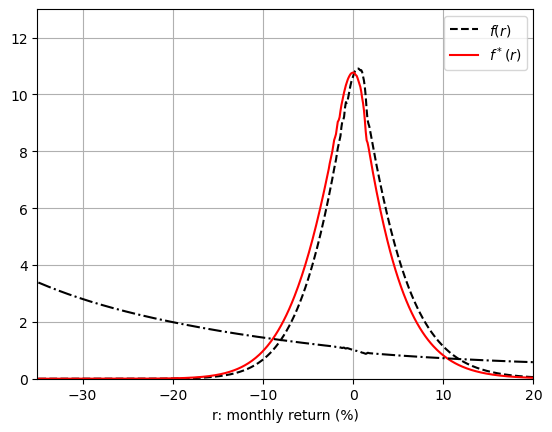

In [14]:
EfP_np = EfP.to('cpu').detach().numpy()
EfQ_np = EfQ.to('cpu').detach().numpy()
KS_vec_np = KS_vec.to('cpu').detach().numpy()
plt.plot((KS_vec_np[1:-1].flatten()-1)*100,EfP_np,label = r'$f(r)$', color = 'black', linestyle = 'dashed')
plt.plot((KS_vec_np[1:-1].flatten()-1)*100,EfQ_np,label = r'$f^*(r)$', color = 'red')
plt.plot(((KS_vec_np[1:-1].flatten()-1)*100),EfQ_np/EfP_np, color = 'black', linestyle = 'dashdot')
plt.xlim(-0.35*100,0.2*100)
plt.ylim(0,13)
plt.grid()
plt.legend()
plt.xlabel('r: monthly return (%)')
plt.show()

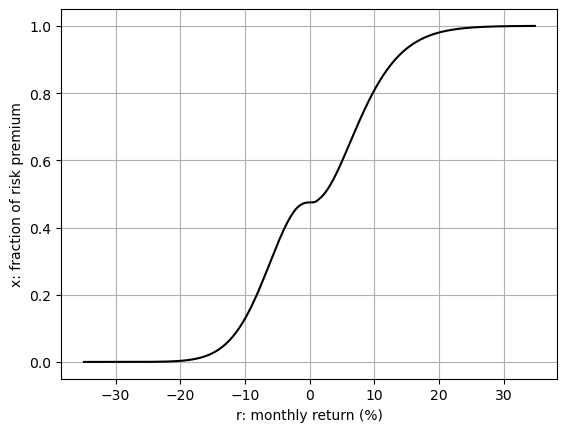

In [15]:
intP = EfP*(KS_vec[1:-1].flatten()-1)
intQ = EfQ*(KS_vec[1:-1].flatten()-1)
EPP = torch.cumsum(intP,0)*delKS
EPQ = torch.cumsum(intQ,0)*delKS
EPx = (EPP - EPQ)/(EPP[-1] - EPQ[-1])
plt.plot(((KS_vec_np[1:-1].flatten()-1)*100),EPx.to('cpu').detach().numpy(), color = 'black')
plt.grid()
plt.xlabel('r: monthly return (%)')
plt.ylabel('x: fraction of risk premium')
plt.show()

# Beeler and Campbell (2009)

100%|██████████| 500/500 [00:01<00:00, 434.26it/s]


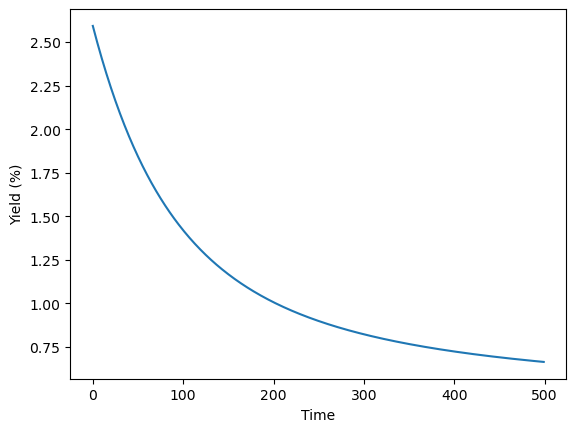

In [37]:
# yield curve
EU_term   = beta * torch.exp((alpha-1)*(g+x_grid)+(alpha-1)**2*s2_grid/2) # (nS2*nX)x1
mc        = ((vc**rho-(1-beta))/beta)**(1/rho) # (nS2*nX)x1
EZ_term   = (poly_pred(Xp, theta, shape_VC)/mc) ** (alpha-rho) # (nS2*nX)x(n*n)
EM        = EU_term * (EZ_term @ PE2) # (nS2*nX)x1

Hmax = 500
EM_h = torch.zeros((nS2*nX,Hmax), dtype=torch.float64, device='cuda')
EM_h[:,[0]] = EM 
# EM_h is the cumulative of M: 
# EM_h[:,[0]] = E_t(M_{t+1})
# EM_h[:,[h]] = E_t(\prod_{j=t+1}^{t+h} M_j) = E_t(M_{t+1} * M_{t+2} * ... * M_{t+h})
for h in tqdm(range(1,Hmax)): 
    theta_EM       = poly_fit(X, EM_h[:,[h-1]]) # fit E_t(M_{t+1} * M_{t+2} * ... * M_{t+h})
    EM_h[:,[h]] = EU_term * ((poly_pred(Xp, theta_EM, shape_VC)*EZ_term) @ PE2)
    
yields = torch.zeros(Hmax, dtype=torch.float64, device='cuda')
for h in tqdm(range(Hmax)):
    theta_yeild = poly_fit(X, -torch.log(EM_h[:,[h]])/(h+1)*1200)
    yields[h] = poly_pred(X_sim, theta_yeild, s2_sim.shape).mean()

plt.plot(yields.to('cpu'))
plt.xlabel('Time')
plt.ylabel('Yield (%)')
plt.show()

# van Binsbergen, Brandt, and Koijen (2012)

In [64]:
# Dividend strip P/D ratios
Hmax     = 500
ER_strip  = torch.zeros(Hmax, dtype=torch.float64, device='cuda')
ER2_strip = torch.zeros(Hmax, dtype=torch.float64, device='cuda')
D_term = torch.exp(g + phi*x_grid + psi_d**2*s2_grid/2)
D2_term   = torch.exp(2*g + 2*phi*x_grid + 4*psi_d**2*s2_grid/2)
MD_term = EU_term * D_term
PD_strip = torch.zeros((nS2*nX,Hmax), dtype=torch.float64, device='cuda')
PD_strip[:,[0]] = MD_term*(EZ_term@PE2)
ER_strip[0]  = torch.mean(D_term/PD_strip[:,[0]])
ER2_strip[0] = torch.mean(D2_term/PD_strip[:,[0]]**2)
for h in tqdm(range(1,Hmax)):
    theta_PD = poly_fit(X, PD_strip[:,[h-1]])
    PD_strip_p = poly_pred(Xp, theta_PD, shape_VC)
    PD_strip[:,[h]] = MD_term*((EZ_term*PD_strip_p)@PE2)
    ER_h  = PD_strip_p@PE2 / PD_strip[:,[h]] * D_term
    ER2_h = (PD_strip_p**2)@PE2 / PD_strip[:,[h]]**2 * D2_term
    theta_ER_h = poly_fit(X, ER_h)
    theta_ER2_h = poly_fit(X, ER2_h)
    ER_strip[h] = poly_pred(X_sim, theta_ER_h, s2_sim.shape).mean()
    ER2_strip[h] = poly_pred(X_sim, theta_ER2_h, s2_sim.shape).mean()

100%|██████████| 499/499 [00:43<00:00, 11.51it/s]


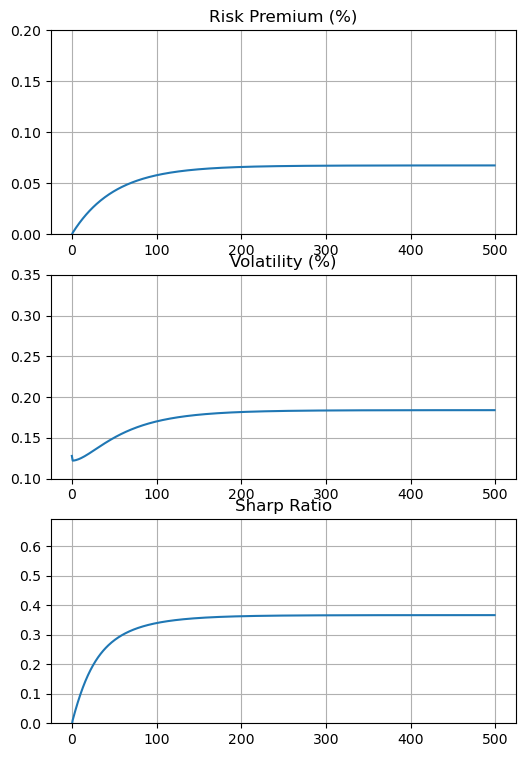

In [67]:
theta_EM = poly_fit(X, EM)
EM_fit = poly_pred(X_sim, theta_EM, s2_sim.shape)
E_Rf = (1/EM_fit).mean()
Risk_Premium = (ER_strip-E_Rf)*12
Volatility = torch.sqrt((ER2_strip - ER_strip**2)*12)
Sharp_ratio = (ER_strip-E_Rf)/torch.sqrt(ER2_strip - ER_strip**2) * np.sqrt(12)
fig, ax = plt.subplots(3,1,figsize=(6,9))
ax[0].plot(Risk_Premium.to('cpu'))
ax[0].set_title('Risk Premium (%)')
ax[0].set_ylim(0,0.2)
ax[0].grid()
ax[1].plot(Volatility.to('cpu'))
ax[1].set_title('Volatility (%)')
ax[1].set_ylim(0.1,0.35)
ax[1].grid()
ax[2].plot(Sharp_ratio.to('cpu'))
ax[2].set_title('Sharp Ratio')
ax[2].set_ylim(0,0.69)
ax[2].grid()
plt.show()